# Tutorial3: scDREAMER-Sup semi-supervised integration of Healthy Heart dataset

<a href="https://colab.research.google.com/github/Zafar-Lab/scDREAMER/blob/main/2109_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import scanpy as sc
os.environ["CUDA_VISIBLE_DEVICES"] = "1" 
import random
import numpy as np
import tensorflow as tf2
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 

2023-09-21 20:04:48.727265: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-21 20:04:49.317453: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Instructions for updating:
non-resource variables are not supported in the long term


Visualization of Healthy Heart data

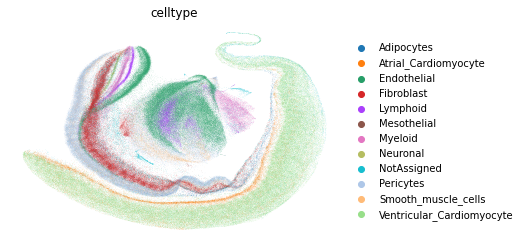

In [2]:
adata = sc.read_h5ad("/home/ajita/Documents/data_integration/Healthy_Heart/Healthy_human_heart_adata_subset.h5ad")
sc.pp.neighbors(adata, use_rep = "X") 
sc.tl.umap(adata)
sc.pl.umap(adata, color = "celltype", frameon = False)

Setting seed for reproducibility

In [2]:

np.random.seed(0)
tf.set_random_seed(0)
random.seed(0)
tf2.random.set_seed(0)
tf2.keras.utils.set_random_seed(0)


Building model

In [3]:


name = "Lung"
name = "Human_Retina"
name = "Human_Mouse"
name = "Immune_Human"
name = "Healthy_Heart"

"""
NOTE:
Run setting as follows:
0: Supervised setting: In case of healthy heart, semi-supervised setting for "Not-assigned" cells
10: 10 percent missing labels data
20: 20 percent missing labels data
50: 50 percent missing labels data
"""
run_setting = 0

Run setting

In [4]:


path = "/home/ajita/Documents/data_integration/"

data_path = {
    
"Immune_Human" : {0: path + "Immune/Immune_ALL_human.h5ad",
                  10: path + "Immune/Immune_Human_NA_0.1.h5ad",
                  20: path + "Immune/Immune_Human_NA_0.2.h5ad",
                  50: path + "Immune/Immune_Human_NA_0.5.h5ad"
                 },
"Healthy_Heart" : {0: path + "Healthy_Heart/Healthy_human_heart_adata_subset.h5ad"
                 }
}


batch_key_dict = {'Immune_Human' : 'batch',
                 'Lung' : 'batch',
                 'Pancreas' : 'tech',
                 'Human_Mouse' : 'batch',
                 'Human_Retina': "Batch",
                 "Healthy_Heart" : "sampleID"
                 
                }

cell_type_key_dict = {
    
    "Immune_Human" : {0: "final_annotation", 10: "final_annotation_NA",
    20: "final_annotation_NA", 50: "final_annotation_NA"
    } ,
    "Healthy_Heart" : {0: "celltype_NA" }  
}


lr = {"lr_ae" : 0.0002, "lr_dis": 0.0007}
lr_big_data = {"lr_ae" : 0.0001, "lr_dis": 0.00001}

learning_rate = {
"Immune_Human" : {0: lr, 10: lr, 20: lr, 50: lr },    # Learning rate for small datasets
"Healthy_Heart" : {0: lr_big_data, 20: lr_big_data, 50: lr_big_data}} # Learning rate for large datasets


plot_cell_type_dict = {
                    "Healthy_Heart" : "celltype",
                    'Immune_Human' : 'final_annotation', 
                 'Lung' : 'cell_type',
                 'Pancreas' : 'celltype',
                 'Human_Mouse' : "celltype",
                 "Human_Retina":"Subcluster"
                    } 

scDREAMER model

In [ ]:

import scDREAMER_SUP.model as model


run_config = tf.ConfigProto()

run_config.gpu_options.per_process_gpu_memory_fraction = 0.333
run_config.gpu_options.allow_growth = True

with tf.Session(config = run_config) as sess:

    dreamer = model.scDREAMER_SUP(
        sess,
        epoch = 300,
        dataset_name = data_path[name][run_setting],
        batch = batch_key_dict[name],
        cell_type = cell_type_key_dict[name][run_setting],
        plot_cell_type = plot_cell_type_dict[name],
        name = name,
        lr_ae = learning_rate[name][run_setting]['lr_ae'],
        lr_dis = learning_rate[name][run_setting]['lr_dis']
        )

    dreamer.train_cluster()

    

2023-09-21 20:04:59.946007: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5367 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:d8:00.0, compute capability: 7.5


Loading dataset
Preprocessing...
here [10 11 11 ...  2  2  2]
Shape self.data_train: (485511, 2000)
Shape self.data_test: (485511, 2000)
encoder input shape  Tensor("concat:0", shape=(?, 2147), dtype=float32)
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use `tf.cast` instead.
decoder input shape  Tensor("concat_2:0", shape=(?, 157), dtype=float32)
KL gaussian z Tensor("mul_12:0", shape=(?,), dtype=float32)
KL gaussian l Tensor("mul_11:0", shape=(?,), dtype=float32)
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

scDREAMER-Sup on DataSet /home/ajita/Documents/data_integration/Healthy_Heart/Healthy_human_heart_adata_subset.h5ad ... 


2023-09-21 20:06:58.537832: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:353] MLIR V1 optimization pass is not enabled


Epoch : [0] ,  a_loss = 217.2630
Epoch : [10] ,  a_loss = 194.5482
Epoch : [20] ,  a_loss = 189.7468
Epoch : [30] ,  a_loss = 187.8285
Epoch : [40] ,  a_loss = 186.5633
Epoch : [50] ,  a_loss = 186.2601
Epoch : [60] ,  a_loss = 185.5387
Epoch : [70] ,  a_loss = 184.7160
Epoch : [80] ,  a_loss = 184.6446
Epoch : [90] ,  a_loss = 184.2780
Epoch : [100] ,  a_loss = 183.8163
Epoch : [110] ,  a_loss = 183.4391
Epoch : [120] ,  a_loss = 182.9392
Epoch : [130] ,  a_loss = 182.6407
Epoch : [140] ,  a_loss = 181.9946
Epoch : [150] ,  a_loss = 181.7168
Epoch : [160] ,  a_loss = 181.2697
Epoch : [170] ,  a_loss = 180.9640
Epoch : [180] ,  a_loss = 180.4101
Epoch : [190] ,  a_loss = 180.0579
Epoch : [200] ,  a_loss = 179.8580
Epoch : [210] ,  a_loss = 179.6591
Epoch : [220] ,  a_loss = 179.5249
Epoch : [230] ,  a_loss = 179.5214
Epoch : [240] ,  a_loss = 179.6433
Epoch : [250] ,  a_loss = 179.9576
Epoch : [260] ,  a_loss = 179.8742
Epoch : [270] ,  a_loss = 180.0580
Epoch : [280] ,  a_loss = 180.1